In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from astropy.coordinates import Angle
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation, HADec
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128
import cmcrameri.cm as cmc
from astropy.io import fits
from io import BytesIO
import base64

In [4]:
const_c = c.value   # speed of light [m/s]
frequency = 93.7e9              # observing frequency [Hz]
wavelength = const_c/frequency # receiving wavelength [metres]

# Funciones

In [5]:
def weighting_scheme(weights, uv_pix_1d, N, scheme="natural", robust_param=2.):
    """ 
    weigths: array one likes
    uv_pix_1d: 
    N: pix img
    scheme: tipo de ponderación. natural, uniform, robust.
    
    """
    weights_bincount = np.bincount(uv_pix_1d, weights, minlength=N*N)
    weights_w_1d = weights_bincount[uv_pix_1d]
    
    if scheme.lower() == "natural":
        return weights
    elif scheme.lower() == "uniform":
        return weights/weights_w_1d
    elif scheme.lower() == "robust":
        f_squared_num = (5.* np.power(10, -robust_param))**2
        f_squared_den = np.sum(weights_w_1d**2)/np.sum(weights)
        f_squared = f_squared_num/f_squared_den
        return weights/(1.+(weights_w_1d*f_squared))
    else:
        raise ValueError("Not known scheme")

In [6]:
def _earthlocation_to_altaz(location, reference_location):

    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [7]:
def earth_location_to_local_enu(location, reference_location):

    altaz = _earthlocation_to_altaz(location, reference_location)
    ned_coords =  altaz.cartesian.xyz
    enu_coords = ned_coords[1], ned_coords[0], -ned_coords[2]
    return np.array(enu_coords)


In [8]:
def enu_to_local_altaz(enu_baselines, distance):
    elevation = np.arctan2(enu_baselines[0], enu_baselines[1])
    azimuth = np.arcsin(enu_baselines[2]/distance)
    return elevation, azimuth


In [9]:
def calc_RR(H,dec):
    """
    H: array de ángulo horario
    dec: declinación en radianes.

    Dado la rotación de la tierra, el objeto se "desplaza" en el cielo, por lo tanto se utiliza el
    ángulo horario y declinación para seguir su posición en el cielo.
    """
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R


In [10]:
def compute_h(hObs, gradDec, t_muestreo):

    """ 
    hObs: tiempo de observación en horas
    gradDec: declinación en grados
    t_muestreo: tiempo de muestreo en minutos
       """

    observacion_grados = hObs * 15.0
    HA = np.arange(-np.radians(observacion_grados), np.radians(observacion_grados), np.radians((t_muestreo/60)*15))  # [radianes]
    dec = np.radians(gradDec)
    return HA, dec


In [11]:
def grid_sampling(piximg, max_B, coverage, wavelength, scheme, robust_param):
    """ 
    piximg: cantidad de pixeles de la imagen modelo, tiene que ser nxn
    max_B: baseline mas largo
    uvcoverage: array uv cobertura
    wavelength: longitud de onda
    scheme: tipo de esquema, natural, uniform o robust

   """
    #sampling = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    #uvgrid = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    min_lambda=wavelength #minima longitud de onda lambda
    delta_x = (min_lambda / max_B) / 7
    delta_u = 1 / (piximg * delta_x)

    u_pixel2 = np.floor(coverage[:, 0] / delta_u + piximg // 2).astype(int)
    v_pixel2 = np.floor(coverage[:, 1] / delta_u + piximg // 2).astype(int)

    weights = np.ones_like(u_pixel2, dtype=np.float32).ravel()
    uv_pix_1d = piximg * v_pixel2 + u_pixel2
    weights_after_scheme = weighting_scheme(weights, uv_pix_1d, piximg, scheme, robust_param)
    weights_1d = np.bincount(uv_pix_1d, weights_after_scheme, minlength=piximg*piximg)
    weight_image = np.reshape(weights_1d, (piximg,piximg))
    
    
    #psf
    psf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(weight_image)))
    fft_norm = np.max(psf.real)
    psf/= fft_norm 
    
    return weight_image, psf


In [12]:
def baselines(enu_coords):
    """
    enu_coords: arreglo de coordenadas en el sistema de referencia plano tangente local (ENU)
    """
    b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
    b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]
    return b_enu


In [2]:
def bENU_to_bEquatorial(b_enu, lat_obs):
    """
    b_enu: coordenadas de los baselines en el sistema de referencia plano tangente local (ENU)
    lat_obs: latitud del centro del observatorio, expresado en grados
    """
    latitude = np.radians(lat_obs)
    abs_b = np.sqrt(np.sum(b_enu**2, axis=0))

    azimuth, elevation = enu_to_local_altaz(b_enu, abs_b)

    x_equatorial = np.cos(latitude) * np.sin(elevation) - np.sin(latitude) * np.cos(elevation) * np.cos(azimuth)
    y_equatorial = np.cos(elevation) * np.sin(azimuth)
    z_equatorial = np.sin(latitude) * np.sin(elevation) + np.cos(latitude) * np.cos(elevation) * np.cos(azimuth)

    baseline_equatorial = abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])
    
    return baseline_equatorial


In [14]:
def coverage(baselines, HA, dec, wavelength):
    """
    baselines: arreglo de coordenadas de los baselines en el sistema ecuatorial
    HA: Ángulo horario en horas
    dec: declinación en radianes,
    wavelength: longitud de onda
    """
    R_matrix = calc_RR(HA, dec)
    uvw_dot = np.sum(R_matrix[...,np.newaxis]*baselines[np.newaxis,:,np.newaxis,:], axis=1)
    UV_coverage = np.column_stack((uvw_dot[0].reshape(-1), uvw_dot[1].reshape(-1)))/wavelength

    return UV_coverage


In [15]:
def fft_model_image(path):
    img = cv2.imread(path,0)
    ft_data = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
    pix = img.shape[0]
    return pix, ft_data


In [16]:
def geodetic_to_enu(coords, reference_loc):
    """

    coords: array coordenadas geodeticas
    reference_loc: array punto de referencia/centro del conjunto de antenas
    
    """
    ant_pos = EarthLocation.from_geodetic(coords[:,1], coords[:,0], coords[:,2])
    ref_loc = EarthLocation.from_geodetic(reference_loc[1],reference_loc[0],reference_loc[2])
    enu_coords = earth_location_to_local_enu(ant_pos, ref_loc)
    return enu_coords


In [17]:
def new_positions(df, reference, scale):

    """
    df: array de posiciones de dispositivos en el sistema geodetico
    reference: array punto de referencia en el sistema geodetico
    scale: escala en metros.
    
    https://www.movable-type.co.uk/scripts/latlong.html#ellipsoid

    
    
    """

    if scale == 1:
        return df
    else:

        lats = df[:,0]
        lons = df[:,1]
        
        # Bearing
        dLons = np.radians(lons - reference[1])
        y = np.sin(dLons) * np.cos(np.radians(lats))
        x = np.cos(np.radians(reference[0])) * np.sin(np.radians(lats)) - np.sin(np.radians(reference[0])) * np.cos(np.radians(lats)) * np.cos(dLons)
        bearing = np.degrees(np.arctan2(y, x))
        bearing = np.trunc((bearing + 360) % 360)

        # Nuevas posiciones
        R = 6371000
        latRef = np.radians(reference[0])
        lonRef = np.radians(reference[1])
        bearing = np.radians(bearing)

        delta_lats = np.radians(lats) - latRef
        delta_lons = np.radians(lons) - lonRef

        a = np.sin(delta_lats / 2.0)**2 + np.cos(latRef) * np.cos(np.radians(lats)) * np.sin(delta_lons / 2.0)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        
        # Calcular la distancia para cada par de puntos
        distances = (R * c) * scale 

        lat2 = np.arcsin(np.sin(latRef) * np.cos(distances / R) + np.cos(latRef) * np.sin(distances / R) * np.cos(bearing))
        lon2 = lonRef + np.arctan2(np.sin(bearing) * np.sin(distances / R) * np.cos(latRef), np.cos(distances / R) - np.sin(latRef) * np.sin(lat2))
        

        arr = np.column_stack((np.degrees(lat2), np.degrees(lon2), df[:,2]))

        return arr

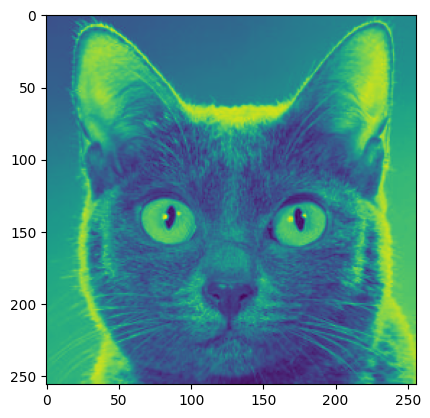

In [18]:
# Cargar la imagen como fuente de luz
image = cv2.imread('cat2.jpg',0)
pix = image.shape[0]
plt.imshow(image)
plt.show()
ft_data = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))



# Ejemplo 1

In [19]:
# 5 puntos de 10 metros, un punto de 7 metros desde el punto de referencia
data = [
    [-41.462072, -72.921443, 100],
    [-41.462062, -72.921361, 100],
    [-41.462026, -72.921359, 100],
    [-41.461987, -72.921365, 100],
    [-41.462001, -72.921430, 100],
    [-41.462021, -72.921459, 100]
]

data = np.array(data)
ref = np.array((-41.462040, -72.921412,100))

In [20]:
# 5 puntos de 30 metros, un punto de 30 metros desde el punto de referencia
data = [
    [-41.462257, -72.921620, 100],
    [-41.462191, -72.921067, 100],
    [-41.461928, -72.921035, 100],
    [-41.461822, -72.921213, 100],
    [-41.461760, -72.921533, 100],
    [-41.461911, -72.921723, 100]
]

data = np.array(data)
ref = np.array((-41.462040, -72.921412,100))

In [21]:
new_pos = new_positions(data, ref, 1)

In [22]:
enu_coords = geodetic_to_enu(new_pos, ref)

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

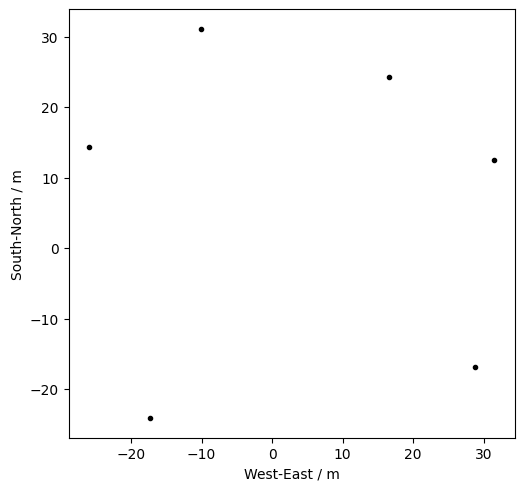

In [23]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [24]:
baseline_enu = baselines(enu_coords)

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

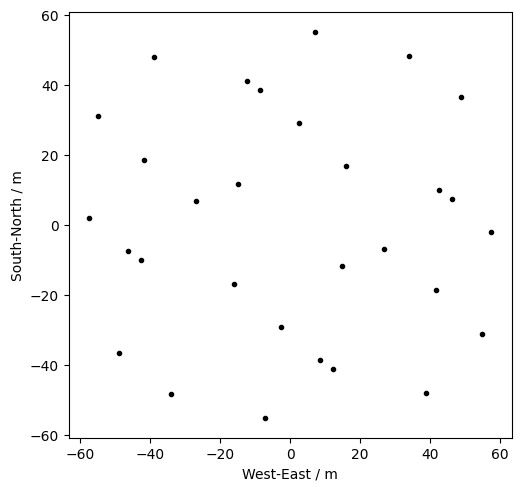

In [25]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(baseline_enu[0], baseline_enu[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [26]:
baseline_equatorial = bENU_to_bEquatorial(baseline_enu, ref[0])

In [27]:
HA, dec = compute_h(5, 25, 6)

In [28]:
cover = coverage(baseline_equatorial, HA, dec, wavelength)

Text(0, 0.5, '$v\\ k\\lambda$')

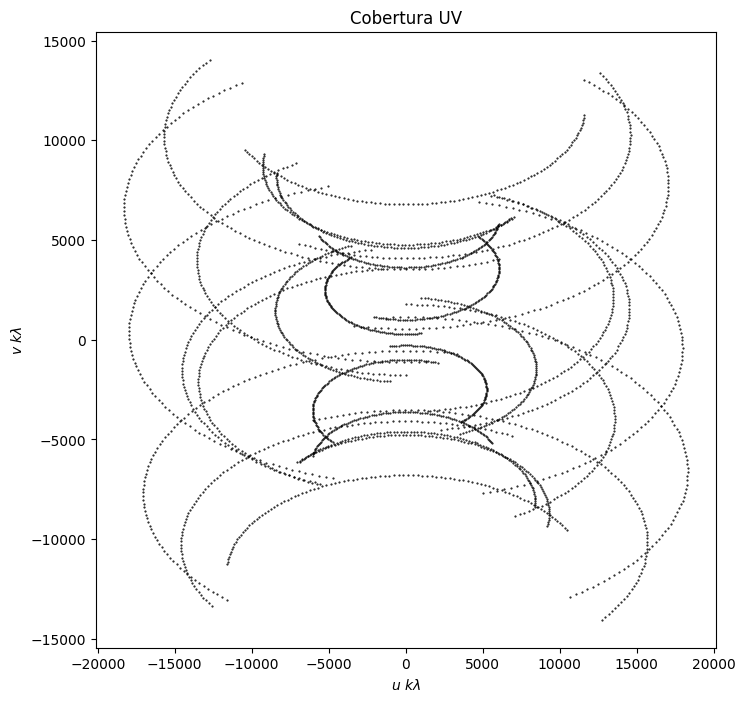

In [29]:
fig = plt.figure(figsize=(8,8))
plt.title("Cobertura UV")
plt.scatter(x=cover[:,0],y=cover[:,1], c="black", marker='.',s=1)
plt.xlabel(r'$u\ k\lambda$')  # Usa 'r' antes de la cadena de texto para que Python la trate como raw string
plt.ylabel(r'$v\ k\lambda$')

In [92]:
# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 150  
# plt.ioff()
# fig, ax = plt.subplots()

# def animate(t):
#     plt.cla()
#     plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

# matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA))

In [30]:
sampling, psf2 = grid_sampling(pix, np.max(np.abs(baseline_equatorial)), cover, wavelength, "uniform", 1)

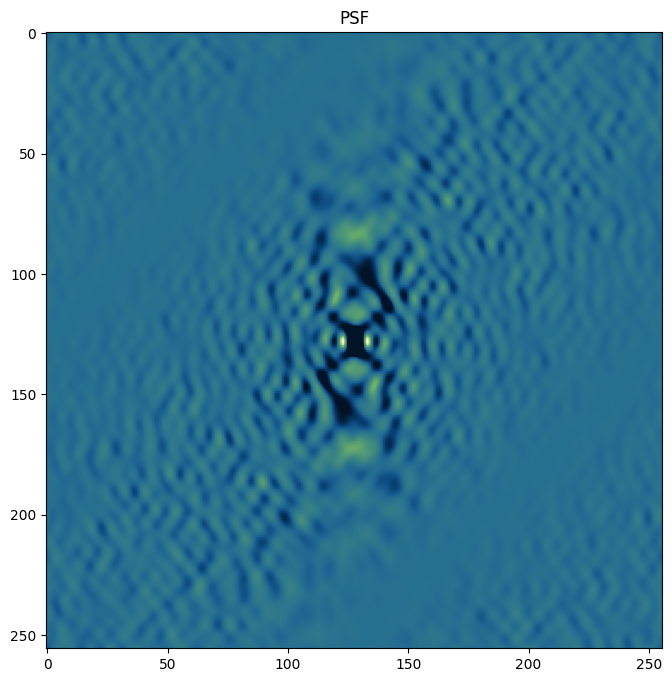

In [31]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('PSF')
plt.imshow(psf2.real, cmap=cmc.navia_r, vmax=0.1)

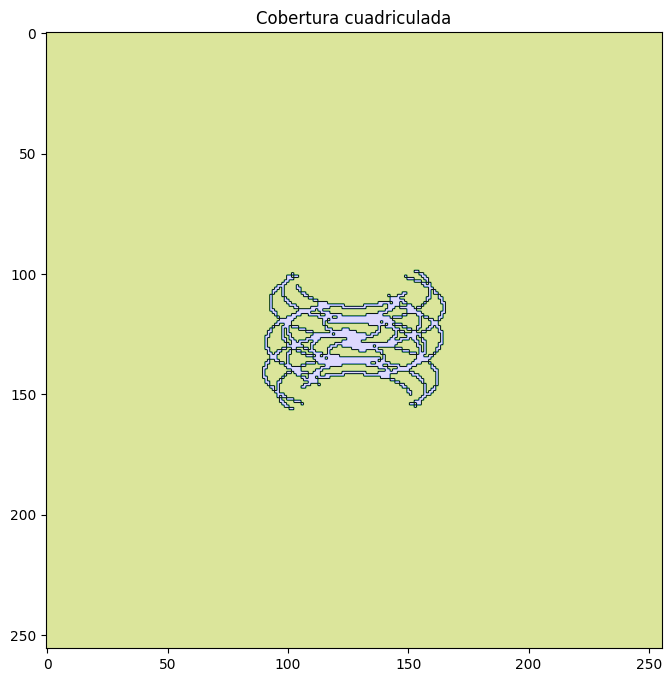

In [32]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('Cobertura cuadriculada')
plt.imshow(sampling, cmap=cmc.tofino_r)

In [33]:
new_obs_EJ1 = (np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(ft_data*sampling))))
obs= (np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(ft_data*sampling)))).real
boolean, buffer = cv2.imencode(".png", obs)
stream = BytesIO(buffer)
img_dirty_base64 = base64.b64encode(stream.getvalue()).decode()

In [43]:
img_dirty_base64

'iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AAAgAElEQVR4ATTB3Y4s25YkZDMb090jI3Ltx6Op0zQgQLT4OdBdQCMkJISExA1XPGrtlRnhPucwI3IX9X38f+e1Vjux3WEVY9S+DwEa+76PgtfsxH3NuRzHQbyu87rmmtdcDqWSkIA1qkgQROwEKhGExHR3wHg5rCq42x33m8n6C4nEdtuOE9bYijY0Bns1agym2wBFlQSEEAUCHNtx3PatxMR2B6ohIqCIgCTIse2jCK/J/+c65+oEiQ2K6XAcxy6CNbZtCF7t2D2v1XYSIJ7Xdc215pzLoN7IhKptlEAAiZ2wJBAs0r0MML0cVQnpbsftTkhpVBUZx27/M9TYSjE4Sulljm3A3SEplUSAEBgkUO23220fAuz8QI0hOqCIBEDCse2baK/F//s8r9V4SwIi7tT+cdsKAGsbQ0g7ca81V9vBm9e8rmutNedsQ28UAGnbxhCB/HBAiQQkxatNwt2GSoLd7dgxQlI1hpg4/hdRbUNJqCF4dbSNSrchilVFghRhO4DGfvs49mLsgECoMQQnIhMHdjj2fQjpNfl/vV7XMkggQNJtbB8fH1slYW3bEPJmr7fudgC413XOudaac3ZAieKbxti3ISJvyBspEqSIXh0S7jYlEWm3kyAIQNUoIXFiO46DGlVIoBK9ulmjmHYgilUlQhLd3YG07cft2ApxSBGhaih2SMZ/ica+DSG9Lv6fr9e1ApEIkl6dOu73204YHPs+FAR2z7W6V9tAes3zmrPXmnN2+AZSVI1t24aIBG9JQJGgyHgZROwGJDJx28GPJNAYRThO4sQJWFVMoBLSy6FKtA3+qDfqLZ6rIdXYjtuxFQJIxSTSINwBEXfbhsa2DyE9T/4fr/NapgQg8Zrm9nG/3zYhqP3Yi0GQNeda7rU6ide8rmt2r7Xm6uAvpDTG2MYQEYBk3ii+SUA7IWInJMHE7QBkYgcaVUy

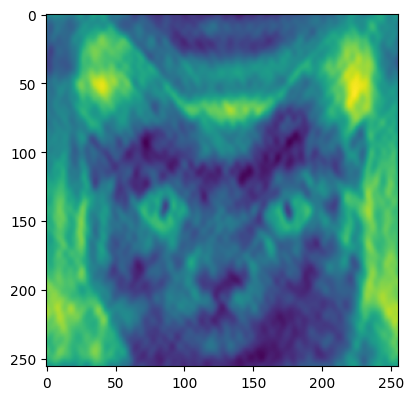

In [34]:
plt.figure(figsize=(10, 10))
plt.subplot(122)
plt.imshow(new_obs_EJ1.real)

# Ejemplo 3 VLA-D

Formas del UV-Coverage de acuerdo al siguiente PDF pag 84:
https://library.nrao.edu/public/collection/02000000000324.pdf

In [ ]:
#posiciones configuración D VLA en coordenadas geograficas (WGS84) - no son exactas
# latitud, longitud, altitud

geoVLA = [[  34.07842625, -107.61828459, 2124.],
       [  34.07808908, -107.61824551, 2124.],
       [  34.07855437, -107.61787752, 2124.],
       [  34.07873509, -107.61831552, 2124.],
       [  34.07850582, -107.61873236, 2124.],
       [  34.07845388, -107.61744277, 2124.],
       [  34.07823558, -107.61685885, 2124.],
       [  34.0779916 , -107.6162074 , 2124.],
       [  34.07762727, -107.61540993, 2124.],
       [  34.07735044, -107.61453944, 2124.],
       [  34.07691797, -107.61358346, 2124.],
       [  34.0765645 , -107.61250526, 2124.],
       [  34.07835685, -107.61913043, 2124.],
       [  34.07807862, -107.61964473, 2124.],
       [  34.07772367, -107.62027238, 2124.],
       [  34.07729173, -107.62099514, 2124.],
       [  34.07685974, -107.62178528, 2124.],
       [  34.07636212, -107.62269102, 2124.],
       [  34.07582174, -107.62364969, 2124.],
       [  34.07930295, -107.61836086, 2124.],
       [  34.07964483, -107.61838996, 2124.],
       [  34.08000375, -107.61844815, 2124.],
       [  34.08055829, -107.61849058, 2124.],
       [  34.08119347, -107.61858118, 2124.],
       [  34.08192272, -107.61862352, 2124.],
       [  34.08272994, -107.61872899, 2124.],
       [  34.08359632, -107.61880064, 2124.]]

geoVLA = np.array(geoVLA)